In [1]:
import tensorflow as tf
slim  = tf.contrib.slim
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
from nets import inception
from preprocessing import inception_preprocessing
import os
from urllib.request import urlopen
from datasets import imagenet
from os import walk
import os
from collections import defaultdict
import json

In [3]:
print (inception.inception_v4.default_image_size)
image_size = inception.inception_v4.default_image_size
checkpoints_dir = '/home/mayoor/dev/ml_tensor/inception'

299


In [4]:
def convert_images(image_file):
    image_string = open(image_file,'rb').read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=True)
    processed_images  = tf.expand_dims(processed_image, 0)
    return processed_images

In [5]:
def convertToTFRecord(data, img_size, depth, label,name):
    writer = tf.python_io.TFRecordWriter(name+'.tfrecords')
    row_len = data.shape[0]
    for i in range(row_len):
        img = data[i]
        example = tf.train.Example(features=tf.train.Features(feature={
            'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[img_size])),
            'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[img_size])),
            'depth': tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label[i])])),
            'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img]))}))
        writer.write(example.SerializeToString())
    writer.close()

In [6]:
def getDataSet(root_folder):
    data = defaultdict(list)
    for (dirpath, dirnames, filenames) in walk(root_folder):
        for image in filenames:
            label = dirpath[dirpath.index('/')+1:]
            image_file = os.path.join(dirpath,image)
            data[label].append(image_file)
    return data

In [7]:
def prepareDataset(root_folder, destination):
    data = getDataSet(root_folder)
    final_data = None
    labels = []
    label_name = {}
    reverse_label = {}
    index = 0
    for label in data:
        image_files = data[label]
        for image_file in image_files:
            pi = convert_images(image_file)
            if final_data != None:
                final_data = np.hstack((final_data, pi))
            else:
                final_data = pi
            labels.append(index)
        label_name[index]=label
        reverse_label[label] = index
        index += 1
    #convertToTFRecord(final_data, 299, 3, labels, destination)
    return label_name, reverse_label

In [8]:
def load_data(reader_queue):
    label = reader_queue[1]
    image_string = tf.read_file(reader_queue[0])
    print (image_string)
    print (label)
    label_oh = tf.one_hot(label, depth=4)
    image = tf.image.decode_image(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=True)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    return tf.reshape(processed_images,[image_size,image_size,3]), label_oh

In [157]:
with tf.Graph().as_default():
    labels = json.loads(open('super_hero_meta.json','r').read())
    reader_queue = tf.train.string_input_producer(getDataSet('super_heros')['batman'])
    image, label = load_data(reader_queue, labels)
    images, labels = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        capacity=50000,
        min_after_dequeue=10000)
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        val = sess.run(k)
        print (val)
        coord.request_stop()
        coord.join(threads)

b'super_heros/batman/18.jpg'


In [22]:
label_name, reverse_label = prepareDataset('test', 'super_heros_test')

with open('super_hero_meta.json','w') as outf:
    outf.write(json.dumps(label_name))
with open('super_hero_meta_reverse.json','w') as outf:
    outf.write(json.dumps(reverse_label))
print (label_name)


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


{0: 'ironman', 1: 'superman', 2: 'spiderman', 3: 'batman'}


In [11]:
def getAllFiles(root_folder, reverse_label):
    d = getDataSet(root_folder)
    files = []
    label_list = []
    for lab in d:
        files = files + d[lab]
        for df in d[lab]:
            label_list.append(reverse_label[lab])
    return files, label_list

In [12]:
def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV4/Logits", "InceptionV4/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v4.ckpt'),
      variables_to_restore)


In [37]:
processed_images = tf.placeholder(tf.float32, shape=[None,image_size,image_size,3])
batch_size = 10
with tf.Graph().as_default():
    labels = json.loads(open('super_hero_meta.json','r').read())
    reverse_labels = json.loads(open('super_hero_meta_reverse.json','r').read())
    #reader_queue = tf.train.string_input_producer(getAllFiles('super_heros'))
    i, ls = getAllFiles('test', reverse_labels)
    igs = tf.convert_to_tensor(i, dtype=tf.string)
    lbs = tf.convert_to_tensor(ls, dtype=tf.int32)
    reader_queue = tf.train.slice_input_producer([igs,lbs],
                                            num_epochs=20,
                                            shuffle=True)
    image, label = load_data(reader_queue)
    images, labels = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        capacity=50000,
        min_after_dequeue=10000)
    print (images.get_shape())
    with slim.arg_scope(inception.inception_v4_arg_scope()):
        logits, _ = inception.inception_v4(images, num_classes=4, is_training=True)
        #init_fn, init_dict = slim.assign_from_checkpoint(os.path.join(checkpoints_dir, 'inception_v4.ckpt'),
        #slim.get_variables_to_restore(exclude=['InceptionV4/Logits", "InceptionV4/AuxLogits']))
        #init_fn = get_init_fn()
        #with tf.Session() as sess:
        #    sess.run(init_fn, init_dict)
    print (labels.get_shape())
    loss = slim.losses.softmax_cross_entropy(logits, labels)
    optimizer = tf.train.AdamOptimizer(1e-4)

    total_loss = slim.losses.get_total_loss()
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    logdir = 'incep_custom'
    slim.learning.train(train_op,logdir,init_fn=get_init_fn(),number_of_steps=20,save_summaries_secs=100,save_interval_secs=600)

Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("input_producer/Gather_1:0", shape=(), dtype=int32)
(10, 299, 299, 3)
(10, 4)
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global step 16: loss = 0.6957 (43.79 sec/step)
INFO:tensorflow:global step 17: loss = 0.6965 (15.81 sec/step)
INFO:tensorflow:global step 18: loss = 0.5309 (16.06 sec/step)
INFO:tensorflow:global step 19: loss = 0.6982 (16.12 sec/step)
INFO:tensorflow:global step 20: loss = 0.4860 (15.88 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model 

{'2': 'spiderman', '0': 'ironman', '3': 'batman', '1': 'superman'}
(1, 299, 299, 3)


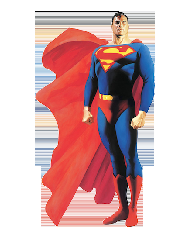

Probability 99.65% => [superman]
Probability 0.12% => [spiderman]
Probability 0.12% => [ironman]


In [55]:
new_checkpoints_dir = '/home/mayoor/dev/ml_tensor/models/slim/incep_custom'
names = json.loads(open('super_hero_meta.json','r').read())
print (names)
with tf.Graph().as_default():
    #url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    url = 'https://upload.wikimedia.org/wikipedia/en/2/21/Web_of_Spider-Man_Vol_1_129-1.png'
    url = 'https://upload.wikimedia.org/wikipedia/en/e/eb/SupermanRoss.png'
    image_string = urlopen(url).read()
    image = tf.image.decode_png(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    print(processed_images.get_shape())
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v4_arg_scope()):
        logits, _ = inception.inception_v4(processed_images, num_classes=4, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    #init_fn, init_dict = slim.assign_from_checkpoint(
    #    os.path.join(checkpoints_dir, 'model.ckpt-20'),
    #    slim.get_model_variables('InceptionV4'))

    variables_to_restore = slim.get_model_variables()
    init_assign_op, init_feed_dict = slim.assign_from_checkpoint('incep_custom/model.ckpt-20', variables_to_restore)
        
    with tf.Session() as sess:
        sess.run(init_assign_op,init_feed_dict)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    #names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(3):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[str(index)]))